## 0. загрузка модулей

In [1]:
%pylab inline

import os, sys, re, glob
# import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [2]:
# import nilearn as nlr
# import nibabel as nib
import nipy

In [ ]:
# # import subprocess
# from nilearn.masking import intersect_masks
# # from nilearn._utils.compat import _basestring
# from nipy.modalities.fmri.glm import FMRILinearModel
# from nipype.caching import Memory as NipypeMemory
# import nipype.interfaces.spm as spm
# from sklearn.externals.joblib import Parallel, delayed, Memory

## 0.1 распаковка zip папок с данными субъектов исследования

In [3]:
dataset_dir = 'C:\\data\\graduate_thesis\\hcp_data_sample\\'

In [12]:
# os.path.normpath(dataset_dir)

In [23]:
%%time

import hashlib, zipfile
subjects_hash_zip_dict = {}
subjects_hash_md5_dict = {}
for (dirpath, dirnames, filenames) in os.walk(dataset_dir):
    for filename in filenames:        
        if filename.endswith('.zip'): 
            file_path = os.path.abspath(os.path.join(dirpath, filename))
            with open(file_path, 'rb') as _zip_f:
                md5 = hashlib.md5()
                md5.update(_zip_f.read())
            subjects_hash_zip_dict[re.findall(r'\d{6}', filename)[0]] = md5.hexdigest()
            print('unzipping... ', filename)    
            zip_ref = zipfile.ZipFile(file_path, 'r')
            zip_ref.extractall(dirpath)
            zip_ref.close()
            print(' ...done')
            os.remove(file_path)
        if filename.endswith('.md5'): 
            file_path = os.path.abspath(os.path.join(dirpath, filename))
            with open(file_path, 'r') as _md5_f:
                subjects_hash_md5_dict[re.findall(r'\d{6}', filename)[0]] = _md5_f.read().split()[0]  
            os.remove(file_path)

unzipping...  100307_3T_tfMRI_SOCIAL_preproc.zip
 ...done
unzipping...  103414_3T_tfMRI_SOCIAL_preproc.zip
 ...done
unzipping...  105115_3T_tfMRI_SOCIAL_preproc.zip
 ...done
Wall time: 1min 21s


In [25]:
unmatched_item = set(subjects_hash_md5_dict.items()) ^ set(subjects_hash_zip_dict.items())
assert len(unmatched_item) == 0, "data is not OK: hash values are missmatched!"

In [26]:
subjects_hash_md5_dict

{'100307': '9ee7b2dd8046f0d6e897ff3bfe79e7b5',
 '103414': '76bff608bcfd2c2025453466ae6e8ae2',
 '105115': 'de109fd050bd1ed7c53f804e130e8fd1'}

## 0.2 распаковка gz файлов во всех вложенных папках

In [4]:
# import gzip
# этот модуль требует прочитать gz файл и потом сохранить его в файл без расширения gz

In [26]:
%%time
# то же самое делают функции библиотек nilearn и nibabel
# сами gz можно не удалять, но они занимают место
from nilearn import image

for (dirpath, dirnames, filenames) in os.walk(dataset_dir):
    for filename in filenames:        
        if filename.endswith('.gz'): 
            file_path = os.path.normpath(os.path.abspath(os.path.join(dirpath, filename)))
            file_name = os.path.basename(file_path)[:-3]
            gz_image = image.load_img(file_path)
            gz_image.to_filename(os.path.join(os.path.dirname(file_path),file_name))            
            os.remove(file_path)
            
print('ungzipping done')
del gz_image

ungzipping done


## 0.3 задание словаря options, в котором определяются шаблоны названия файлов и информация об исследовании (эксперименте)

In [5]:
# @TODO change paths for unix 
options = {'protocol': 'SOCIAL', 
           'dataset_description': 'HCP SOCIAL experiment',   
           'dataset_dir': 'C:\\data\\graduate_thesis\\hcp_data_sample\\',  
           'subject_dirs': '*', 
           'output_dir': 'output', 
           'nruns': 2,
#            'session_1_folder': 'MNINonLinear\\Results\\tfMRI_SOCIAL_RL\\', 
#            'session_2_folder': 'MNINonLinear\\Results\\tfMRI_SOCIAL_LR\\',      
           'session_1_func': 'MNINonLinear\\Results\\tfMRI_SOCIAL_RL\\tfMRI_SOCIAL_RL.nii', 
           'session_2_func': 'MNINonLinear\\Results\\tfMRI_SOCIAL_LR\\tfMRI_SOCIAL_LR.nii',      
#            'brain_mask_template': 'brainmask_fs.2.nii',
           'session_1_brainmask': 'MNINonLinear\\Results\\tfMRI_SOCIAL_RL\\brainmask_fs.2.nii', 
           'session_2_brainmask': 'MNINonLinear\\Results\\tfMRI_SOCIAL_LR\\brainmask_fs.2.nii',      
           'func_write_voxel_sizes': [2.0, 2.0, 2.0], 
           'nslices': 72,
           'TR': 0.72, 
           'TA': 'TR * (1 - 1 / nslices)', 
           'nsubjects': 3,
           'exclude_these_subject_ids': [],
           'include_only_these_subject_ids': [],
           'n_jobs': 32, 
#           # PREPROC PARAMS
#            # smoothing
           'fwhm': 4.0, 
#            'smooth_software': 'spm',
#           # OTHER COMMON
#            'caching': True, 
#            'slicer': 'ortho',  
#            'cut_coords': None, 
#            'threshold': 3, 
#            'cluster_th': 15,   # minimum number of voxels in reported clusters ?
#            'p_value': 0.05,
#            't_value': 8,
#            'voi_radii': 6,
#            'locmax_search_radii': 20,
#           # MATLAB AND SPM SPEC
#            'spm_dir': 'C:\\Program Files\\MATLAB\\spm12', 
#            'matlab_exec': 'C:\\Program Files\\MATLAB\\R2017a'
          }
# hpf = 128

In [31]:
# from utils.io_utils import expand_path, get_relative_path, get_abspath_relative_to_file

In [6]:
# check dataset_dir
dataset_dir = options['dataset_dir']
if not os.path.exists(dataset_dir):
    raise OSError("dataset_dir '%s' doesn't exist" % dataset_dir)
    
# check output_dir
output_dir = os.path.abspath(os.path.join(dataset_dir, options['output_dir']))
# путь может задаваться относительно другой папки
# if output_dir is None:
#     raise OSError(
#         ("Could not expand 'output_dir' : invalid"
#          " path %s (relative to directory %s)") % (options['output_dir'],
#                                                    dataset_dir))

# check subject_dirs
if isinstance(options['subject_dirs'], str):
    subject_dirs = os.path.abspath(os.path.join(dataset_dir, options['subject_dirs']))
else: 
    subject_dirs = options['subject_dirs']
# путь может задаваться относительно другой папки
# if subject_dirs is None:
#     raise OSError(
#         ("Could not expand 'subject_dirs' : invalid"
#          " path %s (relative to directory %s)") % (options['subject_dirs'],
#                                                    dataset_dir))

In [7]:
print('\n', dataset_dir, '\n', output_dir, '\n', subject_dirs)


 C:\data\graduate_thesis\hcp_data_sample\ 
 C:\data\graduate_thesis\hcp_data_sample\output 
 C:\data\graduate_thesis\hcp_data_sample\*


In [8]:
# how many subjects 
nsubjects = options.get('nsubjects', np.inf)
print('nsubjects: ',nsubjects)
exclude_these_subject_ids = options.get(
    'exclude_these_subject_ids', [])
include_only_these_subject_ids = options.get(
    'include_only_these_subject_ids', [])

nsubjects:  3


In [9]:
if isinstance(subject_dirs, str):
    subject_data_dirs = [x for x in sorted(glob.glob(os.path.join(dataset_dir, subject_dirs)))
                         if os.path.isdir(x)]
#     subject_data_dirs = [os.path.join(x, re.findall(r'\d{6}', x)[0]) for x in subject_data_dirs] 
else:
    # list of subjects or subject wildcards
    subject_data_dirs = [os.path.join(dataset_dir, x)
                         for x in subject_dirs]
    aux = []
    for subject_data_dir in subject_data_dirs:
        for x in sorted(glob.glob(os.path.join(dataset_dir, subject_data_dir))):
            if os.path.isdir(x):
                aux.append(x)
    subject_data_dirs = aux    


In [10]:
if not subject_data_dirs:
    warnings.warn("No subject directories found for wildcard: %s" % (
        subject_dirs))

In [11]:
subject_data_dirs

['C:\\data\\graduate_thesis\\hcp_data_sample\\100307',
 'C:\\data\\graduate_thesis\\hcp_data_sample\\103414',
 'C:\\data\\graduate_thesis\\hcp_data_sample\\105115']

In [12]:
sess_func_wildcards = sorted([key for key in list(options.keys())
                           if re.match("session_.+_func", key)])
sess_ids = sorted([re.match("session_(.+)_func", session).group(1)
                for session in sess_func_wildcards])
sess_brainmask_wildcards = sorted([key for key in list(options.keys())
                           if re.match("session_.+_brainmask", key)])

In [13]:
sess_func_wildcards, sess_ids, sess_brainmask_wildcards

(['session_1_func', 'session_2_func'],
 ['1', '2'],
 ['session_1_brainmask', 'session_2_brainmask'])

In [14]:
class SubjectData(object):
    def __init__(self, 
                 subject_id="sub001",
                 data_dir=None,
                 func=None,                  
                 brainmasks=None,                  
                 output_dir=None, 
                 session_output_dirs=None,
                 session_ids=None, 
                 scratch=None, 
                 n_sessions = None,
                 **kwargs):
        self.subject_id = subject_id
        self.data_dir = data_dir
        self.func = func
        self.brainmasks = brainmasks
        self.output_dir = output_dir
        self.session_output_dirs = session_output_dirs
        self.session_ids = session_ids
        self.n_sessions = n_sessions        
        self._set_items(**kwargs)
        self.scratch = output_dir if scratch is None else scratch
        self.session_scratch_dirs = (session_output_dirs if scratch is None
                                     else [scratch] * len(session_output_dirs))
    def _set_items(self, **kwargs):
        for k, v in list(kwargs.items()):
            setattr(self, k, v)
    def __getitem__(self, key):
        return self.__dict__[key]
    def __repr__(self):
        return repr(self.__dict__)

In [15]:
def get_relative_path(ancestor, descendant):
    """
    Get's path of a file or directory (descendant) relative to another
    directory (ancestor). 
    """    
    if ancestor == descendant:
        return ""

    ancestor = ancestor.rstrip("\\")
    descendant = descendant.rstrip("\\")
    right_part = descendant[len(ancestor):].lstrip("\\")
    if right_part is None:
        return None
    else:
        return right_part    
    

In [16]:
subjects = []

for subject_data_dir in subject_data_dirs:
    if len(subjects) == nsubjects:
        # we've had enough subjects already; end
        break
        
    subject_id = os.path.basename(subject_data_dir)
    subject_output_dir = os.path.join(output_dir, subject_id)  
    
    if len(options['include_only_these_subject_ids']) > 0:  
        if not subject_id in options['include_only_these_subject_ids']:
            continue
    
    if len(options['exclude_these_subject_ids']) > 0:  
        if subject_id in options['exclude_these_subject_ids']:
            continue
            
    # grab functional data
    func = []
    brainmasks = []
    session_output_dirs = []
    
    for s, sess_func_wildcard in enumerate(sess_func_wildcards):
        sess_func_wildcard = options[sess_func_wildcard]  
        sess_func = os.path.join(subject_data_dir, sess_func_wildcard)
        if not os.path.isfile(sess_func):        
            raise OSError(
                ("Could not expand 'sess_func_wildcard' : invalid"
                 " path %s (relative to directory %s)") % (sess_func_wildcard,
                                                           subject_data_dir))        
#         # skip session if no data found
#         if not sess_func:
#             warnings.warn(
#                 ("subject %s: No func images found for"
#                  " wildcard %s; Skipping subject" % (subject_id, sess_func_wildcard)))
#             continue
        
        func.append(sess_func)
        sess_dir = os.path.dirname(sess_func)
        # session output dir
        if os.path.basename(sess_dir) != os.path.basename(
                subject_output_dir):
            sess_output_dir = os.path.join(subject_output_dir,
                                           get_relative_path(
                                               subject_data_dir, sess_dir))
        else:
            sess_output_dir = subject_output_dir
            
        if not os.path.exists(sess_output_dir):
            os.makedirs(sess_output_dir)
        
        session_output_dirs.append(sess_output_dir)
        
    for s, sess_brainmask_wildcard in enumerate(sess_brainmask_wildcards):        
        sess_brainmask_wildcard = options[sess_brainmask_wildcard]          
        sess_brainmask = os.path.join(subject_data_dir, sess_brainmask_wildcard)        
        if not os.path.isfile(sess_brainmask):        
            raise OSError(
                ("Could not expand 'sess_brainmask_wildcards' : invalid"
                 " path %s (relative to directory %s)") % (sess_brainmask_wildcard,
                                                           subject_data_dir))        
        brainmasks.append(sess_brainmask)
    
    # make subject data
    subject_data = SubjectData(
        subject_id=subject_id, 
        data_dir=subject_data_dir, 
        func=func,
        brainmasks = brainmasks,
        output_dir=subject_output_dir,
        session_output_dirs=session_output_dirs,
        session_ids=sess_ids,        
        n_sessions = len(sess_ids)
    )

    subjects.append(subject_data)
    
if not subjects:
    warnings.warn(
        "No subjects globbed (dataset_dir=%s, subject_dir_wildcard=%s" % (
            dataset_dir, subject_dir_wildcard))


In [17]:
subjects

[{'session_ids': ['1', '2'], 'n_sessions': 2, 'session_output_dirs': ['C:\\data\\graduate_thesis\\hcp_data_sample\\output\\100307\\MNINonLinear\\Results\\tfMRI_SOCIAL_RL', 'C:\\data\\graduate_thesis\\hcp_data_sample\\output\\100307\\MNINonLinear\\Results\\tfMRI_SOCIAL_LR'], 'subject_id': '100307', 'func': ['C:\\data\\graduate_thesis\\hcp_data_sample\\100307\\MNINonLinear\\Results\\tfMRI_SOCIAL_RL\\tfMRI_SOCIAL_RL.nii', 'C:\\data\\graduate_thesis\\hcp_data_sample\\100307\\MNINonLinear\\Results\\tfMRI_SOCIAL_LR\\tfMRI_SOCIAL_LR.nii'], 'scratch': 'C:\\data\\graduate_thesis\\hcp_data_sample\\output\\100307', 'data_dir': 'C:\\data\\graduate_thesis\\hcp_data_sample\\100307', 'session_scratch_dirs': ['C:\\data\\graduate_thesis\\hcp_data_sample\\output\\100307\\MNINonLinear\\Results\\tfMRI_SOCIAL_RL', 'C:\\data\\graduate_thesis\\hcp_data_sample\\output\\100307\\MNINonLinear\\Results\\tfMRI_SOCIAL_LR'], 'output_dir': 'C:\\data\\graduate_thesis\\hcp_data_sample\\output\\100307', 'brainmasks': ['

In [18]:
len(subjects)

3

In [19]:
subjects[0].func

['C:\\data\\graduate_thesis\\hcp_data_sample\\100307\\MNINonLinear\\Results\\tfMRI_SOCIAL_RL\\tfMRI_SOCIAL_RL.nii',
 'C:\\data\\graduate_thesis\\hcp_data_sample\\100307\\MNINonLinear\\Results\\tfMRI_SOCIAL_LR\\tfMRI_SOCIAL_LR.nii']

-------

## 1. smoothing

In [22]:
from nilearn import image

In [23]:
from sklearn.externals.joblib import Memory

In [28]:
%%time

for subject in subjects:
    cache_dir = os.path.join(subject.output_dir,'cache_dir')
    if not os.path.exists(cache_dir):
        os.makedirs(cache_dir)
    mem = Memory(cache_dir)
    print('Smoothing %s\'s files...'% subject.subject_id)
    func_smoothed = []
    for i, func in enumerate(subject.func):
        out_func = mem.cache(image.smooth_img)(func, options['fwhm'])
        smoothed_name = 's_' + os.path.basename(func)
        smoothed_path = os.path.join(subject.session_output_dirs[i], smoothed_name)
        out_func.to_filename(smoothed_path)
        func_smoothed.append(smoothed_path)
    subject.func_smoothed = func_smoothed
    print("... done.")

Smoothing 100307's files...
________________________________________________________________________________
[Memory] Calling nilearn.image.image.smooth_img...
smooth_img('C:\\data\\graduate_thesis\\hcp_data_sample\\100307\\MNINonLinear\\Results\\tfMRI_SOCIAL_RL\\tfMRI_SOCIAL_RL.nii', 
4.0)
______________________________________________________smooth_img - 30.7s, 0.5min
________________________________________________________________________________
[Memory] Calling nilearn.image.image.smooth_img...
smooth_img('C:\\data\\graduate_thesis\\hcp_data_sample\\100307\\MNINonLinear\\Results\\tfMRI_SOCIAL_LR\\tfMRI_SOCIAL_LR.nii', 
4.0)
______________________________________________________smooth_img - 35.1s, 0.6min
... done.
Smoothing 103414's files...
________________________________________________________________________________
[Memory] Calling nilearn.image.image.smooth_img...
smooth_img('C:\\data\\graduate_thesis\\hcp_data_sample\\103414\\MNINonLinear\\Results\\tfMRI_SOCIAL_RL\\tfMRI_SO

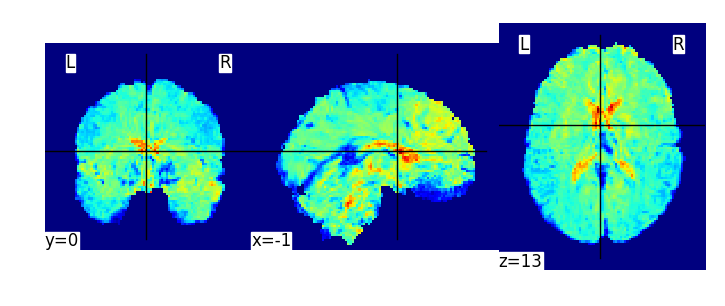

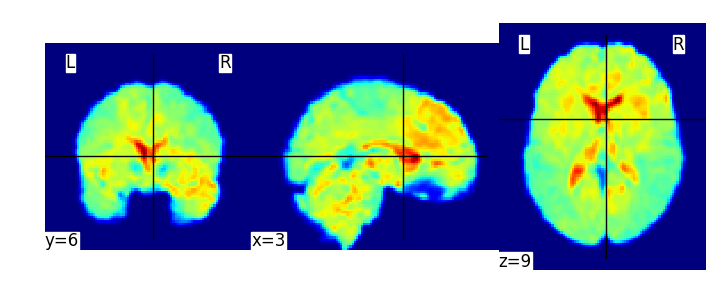

In [29]:
from nilearn import plotting
plotting.plot_img(image.index_img(subject.func[1], 0))
plotting.plot_img(image.index_img(out_func, 0))

------------

## 2.1 чтение файла с описанием эксперимента

In [37]:
def get_abspath_relative_to_file(filename, ref_filename):
    assert os.path.isfile(ref_filename)
    old_cwd = os.getcwd()  # save CWD
    os.chdir(os.path.dirname(ref_filename))  # in context
    abspath = os.path.abspath(filename) 
    os.chdir(old_cwd)  # restore CWD
    return abspath

In [65]:
get_abspath_relative_to_file("./EVs/mental.txt", subject_data_tmp.func[0])

'C:\\data\\graduate_thesis\\hcp_data_sample\\100307\\MNINonLinear\\Results\\tfMRI_SOCIAL_RL\\EVs\\mental.txt'

In [ ]:
timing_files = [tf.replace("EVs", "tfMRI_%s_%s\\EVs" % (
                    options["protocol"], direction)) for tf, direction in zip(timing_files, ['RL', 'LR'])]

In [97]:
import re

# regex for contrasts
CON_REAL_REGX = ("set fmri\(con_real(?P<con_num>\d+?)\.(?P<ev_num>\d+?)\)"
            " (?P<con_val>\S+)")

# regex for "Number of EVs"
NUM_EV_REGX = """set fmri\(evs_orig\) (?P<evs_orig>\d+)
set fmri\(evs_real\) (?P<evs_real>\d+)
set fmri\(evs_vox\) (?P<evs_vox>\d+)"""

# regex for "Number of contrasts"
NUM_CON_REGX = """set fmri\(ncon_orig\) (?P<ncon>\d+)
set fmri\(ncon_real\) (?P<ncon_real>\d+)"""

# regex for "# EV %i title"
EV_TITLE_REGX = """set fmri\(evtitle\d+?\) \"(?P<evtitle>.+)\""""

# regex for "Title for contrast_real %i"
CON_TITLE_REGX = """set fmri\(conname_real\.\d+?\) \"(?P<conname_real>.+)\""""

# regex for "Basic waveform shape (EV %i)"
# 0 : Square
# 1 : Sinusoid
# 2 : Custom (1 entry per volume)
# 3 : Custom (3 column format)
# 4 : Interaction
# 10 : Empty (all zeros)

EV_SHAPE_REGX = """set fmri\(shape\d+\) (?P<shape>[0|1|3])"""

# regex for "Custom EV file (EV %i)"
EV_CUSTOM_FILE_REGX = """set fmri\(custom\d+?\) \"(?P<custom>.+)\""""


def read_fsl_design_file(design_filename):
    # read design file
    design_conf = open(design_filename, 'r').read()

    # scrape n_conditions and n_contrasts
    n_conditions_orig = int(re.search(NUM_EV_REGX,
                                      design_conf).group("evs_orig"))
    n_conditions = int(re.search(NUM_EV_REGX, design_conf).group("evs_real"))
    n_contrasts = int(re.search(NUM_CON_REGX, design_conf).group("ncon_real"))

    # initialize 2D array of contrasts
    contrasts = np.zeros((n_contrasts, n_conditions))

    # lookup EV titles
    conditions = [item.group("evtitle") for item in re.finditer(
                  EV_TITLE_REGX, design_conf)]
    assert len(conditions) == n_conditions_orig

    # lookup contrast titles
    contrast_ids = [item.group("conname_real")for item in re.finditer(
                    CON_TITLE_REGX, design_conf)]
    assert len(contrast_ids) == n_contrasts

    # lookup EV (condition) custom files
    timing_files = [get_abspath_relative_to_file(item.group("custom").replace('..', '.'),
                                                  design_filename)
                    for item in re.finditer(EV_CUSTOM_FILE_REGX, design_conf)]
#     timing_files = [get_abspath_relative_to_file(item.group("custom"),
#                                                   design_filename)
#                     for item in re.finditer(EV_CUSTOM_FILE_REGX, design_conf)]
#     if not os.path.isfile(timing_files[0]):
# #         timing_files = [get_abspath_relative_to_file(item.group("custom")[1:],
# #                                                   design_filename)
# #                     for item in re.finditer(EV_CUSTOM_FILE_REGX, design_conf)]
#         direction = 'RL' if '_RL' in timing_files[0] else 'LR'
#         timing_files = [tf.replace("EVs", "tfMRI_%s_%s\\EVs" % (
#                     options["protocol"], direction)) for tf in timing_files]
    assert os.path.isfile(timing_files[0])

    # lookup the contrast values
    count = 0
    for item in re.finditer(CON_REAL_REGX, design_conf):
        count += 1
        value = float(item.group('con_val'))

        i = int(item.group('con_num')) - 1
        j = int(item.group('ev_num')) - 1

        # roll-call
        assert 0 <= i < n_contrasts, item.group()
        assert 0 <= j < n_conditions, item.group()

        contrasts[i, j] = value

    # roll-call
    assert count == n_contrasts * n_conditions, count

    return conditions, timing_files, contrast_ids, contrasts

In [104]:
# for subject in subjects:
#     subject.design_files = [os.path.join(
#                                     subject.data_dir, ("MNINonLinear\\Results\\tfMRI_%s_%s\\"
#                                     "tfMRI_%s_%s_hp200_s4_level1.fsf") % (
#                                     options["protocol"], direction, options["protocol"], direction))
#                             for direction in ['RL', 'LR']]
#     print(subject.design_files) 

In [106]:
%%time

for subject in subjects:
    if not os.path.exists(subject.output_dir):
        os.makedirs(subject.output_dir)
    
    subject.design_files = [os.path.join(
                                    subject.data_dir, ("MNINonLinear\\Results\\tfMRI_%s_%s\\"
                                    "tfMRI_%s_%s_hp200_s4_level1.fsf") % (
                                    options["protocol"], direction, options["protocol"], direction))
                            for direction in ['RL', 'LR']]
    
    assert len(subject.design_files) == 2
    
    for df in subject_data.design_files:
        if not os.path.isfile(df):
            warnings.warn("It's not a file: %s, occured for %s subject, skipping" % (
                        df, subject.subject_id))
            continue
    
    timing_files = []    
    fsl_condition_ids = []
    fsl_contrast_ids = []    
    contrast_values = []
    print("For subject %s: \r\n" % subject.subject_id)
    for design_file in subject.design_files:
        print("Reading experimental setup from %s ..." % design_file)
        fsl_condition_ids_sess, timing_files_sess, fsl_contrast_ids_sess, contrast_values_sess = \
                read_fsl_design_file(design_file)
        print("... done.\r\n")
        timing_files.append(timing_files_sess) 
        fsl_condition_ids.append(fsl_condition_ids_sess)
        fsl_contrast_ids.append(fsl_contrast_ids_sess)
        contrast_values.append(contrast_values_sess)
        
    subject.timing_files = timing_files
    subject.fsl_condition_ids = fsl_condition_ids
    subject.fsl_contrast_ids = fsl_contrast_ids
    subject.contrast_values = contrast_values

For subject 100307: 

Reading experimental setup from C:\data\graduate_thesis\hcp_data_sample\100307\MNINonLinear\Results\tfMRI_SOCIAL_RL\tfMRI_SOCIAL_RL_hp200_s4_level1.fsf ...
... done.

Reading experimental setup from C:\data\graduate_thesis\hcp_data_sample\100307\MNINonLinear\Results\tfMRI_SOCIAL_LR\tfMRI_SOCIAL_LR_hp200_s4_level1.fsf ...
... done.

For subject 103414: 

Reading experimental setup from C:\data\graduate_thesis\hcp_data_sample\103414\MNINonLinear\Results\tfMRI_SOCIAL_RL\tfMRI_SOCIAL_RL_hp200_s4_level1.fsf ...
... done.

Reading experimental setup from C:\data\graduate_thesis\hcp_data_sample\103414\MNINonLinear\Results\tfMRI_SOCIAL_LR\tfMRI_SOCIAL_LR_hp200_s4_level1.fsf ...
... done.

For subject 105115: 

Reading experimental setup from C:\data\graduate_thesis\hcp_data_sample\105115\MNINonLinear\Results\tfMRI_SOCIAL_RL\tfMRI_SOCIAL_RL_hp200_s4_level1.fsf ...
... done.

Reading experimental setup from C:\data\graduate_thesis\hcp_data_sample\105115\MNINonLinear\Results

In [108]:
subject.timing_files

[['C:\\data\\graduate_thesis\\hcp_data_sample\\105115\\MNINonLinear\\Results\\tfMRI_SOCIAL_RL\\EVs\\rnd.txt',
  'C:\\data\\graduate_thesis\\hcp_data_sample\\105115\\MNINonLinear\\Results\\tfMRI_SOCIAL_RL\\EVs\\mental.txt'],
 ['C:\\data\\graduate_thesis\\hcp_data_sample\\105115\\MNINonLinear\\Results\\tfMRI_SOCIAL_LR\\EVs\\rnd.txt',
  'C:\\data\\graduate_thesis\\hcp_data_sample\\105115\\MNINonLinear\\Results\\tfMRI_SOCIAL_LR\\EVs\\mental.txt']]

In [116]:
subject.fsl_condition_ids

[['RANDOM', 'TOM'], ['RANDOM', 'TOM']]

## 2.2 получение парадигмы исследования

In [143]:
# making frametimes

print(options['TR'])
print(options['nslices'])
print(options['TA'], ':')

options['TA'] = options['TR'] - (options['TR'] / options['nslices'])
print(options['TA'])


0.72
72
TR * (1 - 1 / nslices) :
0.71


In [145]:
options['n_scans'] = image.load_img(subjects[0].func[0]).shape[-1]
print(options['n_scans'])

274


In [148]:
frametimes = np.linspace(0, (options['n_scans'] - 1) * options['TR'], options['n_scans'])

In [223]:
options['frametimes'] = frametimes

In [149]:
frametimes

array([   0.  ,    0.72,    1.44,    2.16,    2.88,    3.6 ,    4.32,
          5.04,    5.76,    6.48,    7.2 ,    7.92,    8.64,    9.36,
         10.08,   10.8 ,   11.52,   12.24,   12.96,   13.68,   14.4 ,
         15.12,   15.84,   16.56,   17.28,   18.  ,   18.72,   19.44,
         20.16,   20.88,   21.6 ,   22.32,   23.04,   23.76,   24.48,
         25.2 ,   25.92,   26.64,   27.36,   28.08,   28.8 ,   29.52,
         30.24,   30.96,   31.68,   32.4 ,   33.12,   33.84,   34.56,
         35.28,   36.  ,   36.72,   37.44,   38.16,   38.88,   39.6 ,
         40.32,   41.04,   41.76,   42.48,   43.2 ,   43.92,   44.64,
         45.36,   46.08,   46.8 ,   47.52,   48.24,   48.96,   49.68,
         50.4 ,   51.12,   51.84,   52.56,   53.28,   54.  ,   54.72,
         55.44,   56.16,   56.88,   57.6 ,   58.32,   59.04,   59.76,
         60.48,   61.2 ,   61.92,   62.64,   63.36,   64.08,   64.8 ,
         65.52,   66.24,   66.96,   67.68,   68.4 ,   69.12,   69.84,
         70.56,   71

In [155]:
def read_timing_files(timing_files, condition_ids=None):
    if not condition_ids is None:
        assert len(condition_ids) == len(timing_files)
    onsets = []
    durations = []
    amplitudes = [] 
    _condition_ids = []
    
    for i, timing_file in enumerate(timing_files):
        timing = np.loadtxt(timing_file)
        if timing.ndim == 1:
            timing = timing[np.newaxis, :]
        if condition_ids is None:
            condition_id = os.path.basename(timing_file).lower(
                ).split('.')[0]            
        else:
            condition_id = condition_ids[i]
        _condition_ids = _condition_ids + [condition_id
                                           ] * timing.shape[0]
        if timing.shape[1]  == 3:
            onsets = onsets + list(timing[..., 0])
            durations = durations + list(timing[..., 1])
            amplitudes = amplitudes + list(timing[..., 2])
        elif timing.shape[1]  == 2:
            onsets = onsets + list(timing[..., 0])
            durations = durations + list(timing[..., 1])
            amplitudes = durations + list(np.ones(len(timing)))
        elif timing.shape[1] == 1:
            onsets = onsets + list(timing[..., 0])
            durations = durations + list(np.zeros(len(timing)))
            amplitudes = durations + list(np.ones(len(timing)))
        else:
            raise TypeError(
                "Timing info must either be 1D array of onsets of 2D "
                "array with 2 or 3 columns: the first column is for "
                "the onsets, the second for the durations, and the "
                "third --if present-- if for the amplitudes; got %s" % timing)
            
    return {'cond_ids': _condition_ids,
            'onset': onsets,
            'duration': durations,
            'modulation': amplitudes}

#     return pd.DataFrame({'name': _condition_ids,
#                          'onset': onsets,
#                          'duration': durations,
#                          'modulation': amplitudes})


In [159]:
%%time

for subject in subjects:
    timing_files_content = []    
    print("Reading timing files for subject %s: " % subject.subject_id)
    for i,timing_files in enumerate(subject.timing_files):
        tf_content = read_timing_files(timing_files, subject.fsl_condition_ids[i])
        timing_files_content.append(tf_content)        
    print("... done.\r\n")
    subject.timing_files_content = timing_files_content    
    

Reading timing files for subject 100307: 
... done.

Reading timing files for subject 103414: 
... done.

Reading timing files for subject 105115: 
... done.

Wall time: 8 ms


In [163]:
subjects[0].timing_files_content[0], subjects[1].timing_files_content[0]

({'cond_ids': ['RANDOM', 'RANDOM', 'RANDOM', 'TOM', 'TOM'],
  'duration': [23.0, 23.0, 23.0, 23.0, 23.0],
  'modulation': [1.0, 1.0, 1.0, 1.0, 1.0],
  'onset': [46.008000000000003,
   84.031999999999996,
   160.08099999999999,
   8.2100000000000009,
   122.056]},
 {'cond_ids': ['RANDOM', 'RANDOM', 'RANDOM', 'TOM', 'TOM'],
  'duration': [23.0, 23.0, 23.0, 23.0, 23.0],
  'modulation': [1.0, 1.0, 1.0, 1.0, 1.0],
  'onset': [46.006999999999998,
   84.031000000000006,
   160.08000000000001,
   8.2100000000000009,
   122.056]})

In [181]:
from nipy.modalities.fmri.experimental_paradigm import BlockParadigm, load_paradigm_from_csv_file

In [178]:
%%time

# experimental paradigm (wrap into class)
for subject in subjects:
    paradigms = []    
    paradigm_paths = []
    print("Wrapping timing files content to paradigm class for %s: " % subject.subject_id)
    for i, tf_content in enumerate(subject.timing_files_content):
        paradigm = BlockParadigm(con_id=tf_content['cond_ids'],
                                 onset=tf_content['onset'], 
                                 duration=tf_content['duration'], 
                                 amplitude=tf_content['modulation'])
        paradigms.append(paradigm)
        sess = subject.session_ids[i]
        paradigm_path = os.path.join(subject.session_output_dirs[i], 'paradigm_sess_%s.csv'%sess)
        print("Saving paradigm to csv... ")
        paradigm.write_to_csv(paradigm_path, sess)
        paradigm_paths.append(paradigm_path)        
    print("... done.\r\n")
    subject.paradigms = paradigms
    subject.paradigm_paths = paradigm_paths

Wrapping timing files content to paradigm class for 100307: 
Saving paradigm to csv... 
Saving paradigm to csv... 
... done.

Wrapping timing files content to paradigm class for 103414: 
Saving paradigm to csv... 
Saving paradigm to csv... 
... done.

Wrapping timing files content to paradigm class for 105115: 
Saving paradigm to csv... 
Saving paradigm to csv... 
... done.

Wall time: 6 ms


In [192]:
# check
p = load_paradigm_from_csv_file(subject.paradigm_paths[0])
p_df = pd.read_csv(subject.paradigm_paths[0], sep=' ', header=None, names=['sess', 'con_id', 'onset', 'duration', 'amplitude'])
p_df

,sess,con_id,onset,duration,amplitude
0,1,RANDOM,46.007,23.0,1.0
1,1,RANDOM,84.031,23.0,1.0
2,1,RANDOM,160.079,23.0,1.0
3,1,TOM,8.196,23.0,1.0
4,1,TOM,122.055,23.0,1.0


## 2.3 регрессоры и контрасты, дизайн матрицы

In [196]:
from nipy.modalities.fmri.design_matrix import make_dmtx

In [224]:
hrf_model = 'canonical'
options['hrf_model'] = hrf_model

In [226]:
for subject in subjects:
    subject.mregressors_file = [os.path.join(
                                    subject.data_dir, ("MNINonLinear\\Results\\tfMRI_%s_%s\\"
                                    "Movement_Regressors.txt") % (options["protocol"], direction))
                                for direction in ['RL', 'LR']]
    X = []
    X_paths = []
    print("Creating design matrix for %s: " % subject.subject_id)
    for i, paradigm in enumerate(subject.paradigms):
        add_regs = np.loadtxt(subject.mregressors_file[i])
        X_sess = make_dmtx(frametimes, paradigm, hrf_model=hrf_model, add_regs=add_regs)
        X.append(X_sess)
        sess = subject.session_ids[i]
        x_path = os.path.join(subject.session_output_dirs[i], 'X_%s.csv'%sess)
        print("Saving session %s design matrix to csv... "%sess)
        X_sess.write_csv(x_path)
        X_paths.append(x_path)   
    print("... done.\r\n")
    subject.X = X
    subject.X_paths = X_paths
        

Creating design matrix for 100307: 
Saving session 1 design matrix to csv... 
Saving session 2 design matrix to csv... 
... done.

Creating design matrix for 103414: 
Saving session 1 design matrix to csv... 
Saving session 2 design matrix to csv... 
... done.

Creating design matrix for 105115: 
Saving session 1 design matrix to csv... 
Saving session 2 design matrix to csv... 
... done.



(<matplotlib.axes._subplots.AxesSubplot at 0xca53b00>,
 <matplotlib.axes._subplots.AxesSubplot at 0xd2abcc0>)

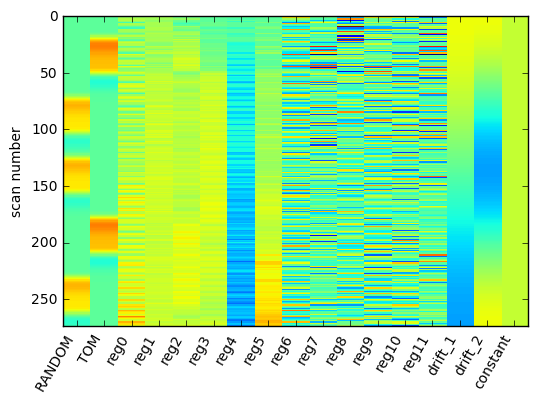

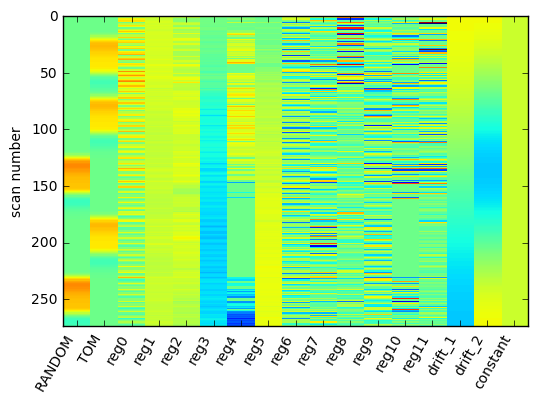

In [232]:
subjects[0].X[0].show(),subjects[0].X[1].show() 

In [248]:
nregressors = subjects[0].X[0].matrix.shape[1]

# contrasts
contrasts = {}

# specify the contrast All_motion [1 1 0 ..]
contrast1 = [1, 1]
contrasts['ALL_MOTION'] = np.hstack(([1,1], np.zeros(nregressors - 2)))

# specify the contrast Tom (Mental) > Random (Rnd) [-1 1 0 ..]
contrast2 = [-1, 1]
contrasts['TOM-RANDOM'] = np.hstack((contrast2, np.zeros(nregressors - len(contrast2))))

# replicate contrasts across sessions
contrasts_repl = dict((cid, [cval] * 2) for cid, cval in contrasts.items())

print(contrasts)

{'ALL_MOTION': array([ 1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.]), 'TOM-RANDOM': array([-1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.])}


In [268]:
subjects[0].X[0].names

['RANDOM',
 'TOM',
 'reg0',
 'reg1',
 'reg2',
 'reg3',
 'reg4',
 'reg5',
 'reg6',
 'reg7',
 'reg8',
 'reg9',
 'reg10',
 'reg11',
 'drift_1',
 'drift_2',
 'constant']

In [254]:
%%time

for subject in subjects:
    nregressors = subject.X[0].matrix.shape[1]
    subject.nregressors = nregressors
    
    nregressors_sess = [X.matrix.shape[1] for X in subject.X]
    subject.nregressors_sess = nregressors_sess
    
    # add contrasts    
    # contrasts
    contrasts = {}

    # specify the contrast All_motion [1 1 0 ..]
    contrast1 = [1, 1]
    contrasts['ALL_MOTION'] = np.hstack(([1,1], np.zeros(nregressors - 2)))

    # specify the contrast Tom (Mental) > Random (Rnd) [-1 1 0 ..]
    contrast2 = [-1, 1]
    contrasts['TOM-RANDOM'] = np.hstack((contrast2, np.zeros(nregressors - len(contrast2))))

    # replicate contrasts across sessions
    contrasts_repl = dict((cid, [cval] * subject.n_sessions) for cid, cval in contrasts.items())
    
    subject.contrasts = contrasts
    subject.contrasts_repl = contrasts_repl
    
    import json
    json.dump(dict((k, list(v)) for k, v in contrasts.items()),
              open(os.path.join(subject.output_dir,
                                "contrasts.json"), "w"))
    

Wall time: 2.5 ms


In [264]:
subject.nregressors_sess, subject.nregressors

([17, 17], 17)

In [265]:
subjects[0].contrasts, subjects[0].contrasts_repl 

({'ALL_MOTION': array([ 1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.]),
  'TOM-RANDOM': array([-1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.])},
 {'ALL_MOTION': [array([ 1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.]),
   array([ 1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.])],
  'TOM-RANDOM': [array([-1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.]),
   array([-1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.])]})

(<matplotlib.axes._subplots.AxesSubplot at 0xca06588>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1126ce10>)

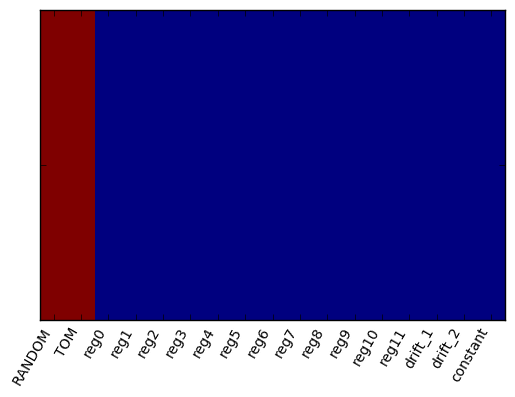

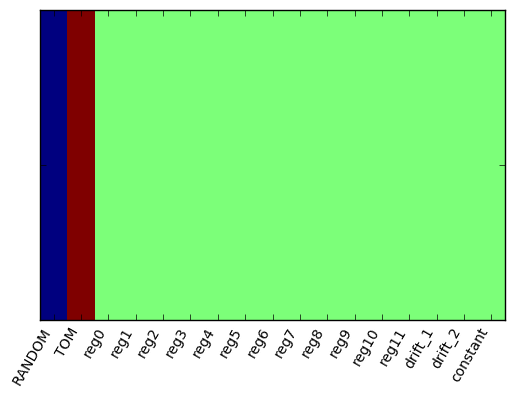

In [250]:
subjects[0].X[0].show_contrast(contrasts['ALL_MOTION']), subjects[0].X[0].show_contrast(contrasts['TOM-RANDOM'])

## 3.1 first-level analysis "Fixed Effect" GLM 

In [275]:
from nipy.modalities.fmri.glm import FMRILinearModel
import nibabel
from nipy.labs.viz import plot_map, cm

In [296]:
%%time

for subject in subjects:
    print(
            'Fitting a "Fixed Effect" GLM for merging RL and LR '
            'phase-encoding directions for subject %s ...' %
            subject.subject_id)
    # Load all the data
    multi_session_model = FMRILinearModel(subject.func_smoothed, [X.matrix for X in subject.X], subject.brainmasks[0])
    # GLM fitting
    multi_session_model.fit(do_scaling=True, model='ar1')
    print("... done.\r\n")

    # save computed mask
    mask_path = os.path.join(subject.output_dir, "mask.nii")
    print("Saving mask image to %s ..." % mask_path)
    nibabel.save(multi_session_model.mask, mask_path)
    print("... done.\r\n")
    
    z_maps = {}
    effects_maps = {}
    map_dirs = {}
    
    for contrast_id, contrast_val in subject.contrasts_repl.items():
        print("\tcontrast id: %s" % contrast_id)
        z_map, eff_map = multi_session_model.contrast(
            contrast_val,
            con_id=contrast_id,
            output_z=True,
            output_effects=True
            )

        # store stat maps to disk
        for map_type, out_map in zip(['z', 'effects'],
                                     [z_map, eff_map]):
            map_dir = os.path.join(
                subject.output_dir, '%s_maps' % map_type)
            map_dirs[map_type] = map_dir
            if not os.path.exists(map_dir):
                os.makedirs(map_dir)
            map_path = os.path.join(
                map_dir, '%s_%s.nii' % (map_type, contrast_id))
            print("\t\tWriting %s ..." % map_path)
            nibabel.save(out_map, map_path)
            
            # collect zmaps for contrasts we're interested in
            if map_type == 'z':
                z_maps[contrast_id] = map_path

            if map_type == 'effects':
                effects_maps[contrast_id] = map_path

    subject.mask = mask_path
    subject.effects_maps = effects_maps
    subject.z_maps = z_maps
    subject.map_dirs = map_dirs   
    

Fitting a "Fixed Effect" GLM for merging RL and LR phase-encoding directions for subject 100307 ...
... done.

Saving mask image to C:\data\graduate_thesis\hcp_data_sample\output\100307\mask.nii ...
... done.

	contrast id: ALL_MOTION
		Writing C:\data\graduate_thesis\hcp_data_sample\output\100307\z_maps\z_ALL_MOTION.nii ...
		Writing C:\data\graduate_thesis\hcp_data_sample\output\100307\effects_maps\effects_ALL_MOTION.nii ...
	contrast id: TOM-RANDOM
		Writing C:\data\graduate_thesis\hcp_data_sample\output\100307\z_maps\z_TOM-RANDOM.nii ...
		Writing C:\data\graduate_thesis\hcp_data_sample\output\100307\effects_maps\effects_TOM-RANDOM.nii ...
Fitting a "Fixed Effect" GLM for merging RL and LR phase-encoding directions for subject 103414 ...
... done.

Saving mask image to C:\data\graduate_thesis\hcp_data_sample\output\103414\mask.nii ...
... done.

	contrast id: ALL_MOTION
		Writing C:\data\graduate_thesis\hcp_data_sample\output\103414\z_maps\z_ALL_MOTION.nii ...
		Writing C:\data\gra

In [520]:
subject.z_maps

{'ALL_MOTION': 'C:\\data\\graduate_thesis\\hcp_data_sample\\output\\105115\\z_maps\\z_ALL_MOTION.nii',
 'TOM-RANDOM': 'C:\\data\\graduate_thesis\\hcp_data_sample\\output\\105115\\z_maps\\z_TOM-RANDOM.nii'}

In [522]:
load(subject.z_maps['ALL_MOTION']).shape

(91, 109, 91)

In [312]:
subject.effects_maps

{'ALL_MOTION': 'C:\\data\\graduate_thesis\\hcp_data_sample\\output\\105115\\effects_maps\\effects_ALL_MOTION.nii',
 'TOM-RANDOM': 'C:\\data\\graduate_thesis\\hcp_data_sample\\output\\105115\\effects_maps\\effects_TOM-RANDOM.nii'}

In [470]:
subject.mask

'C:\\data\\graduate_thesis\\hcp_data_sample\\output\\105115\\mask.nii'

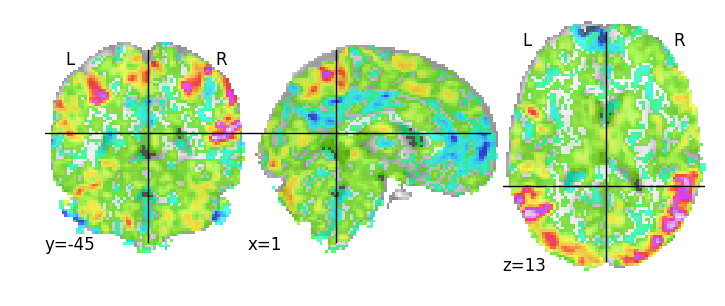

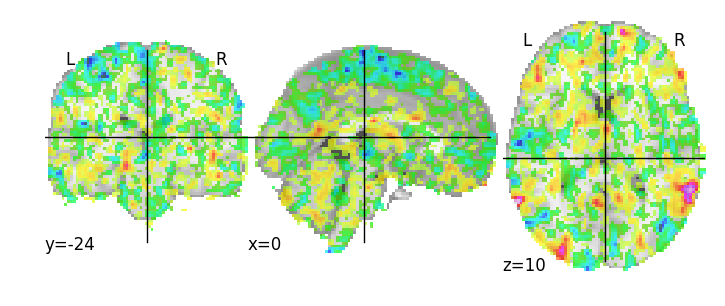

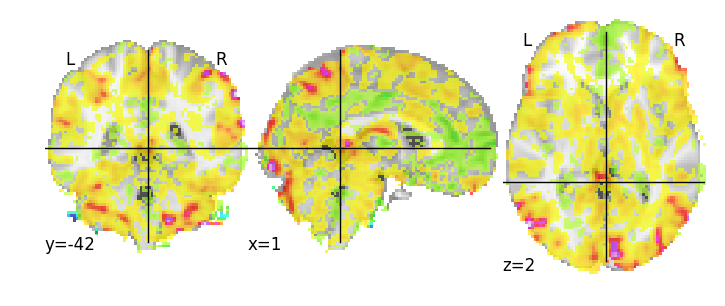

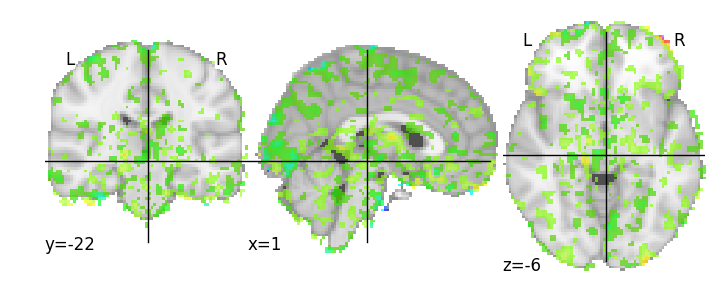

In [508]:
from nilearn import plotting

plotting.plot_roi(image.load_img(subjects[0].z_maps['ALL_MOTION']))
plotting.plot_roi(image.load_img(subjects[0].z_maps['TOM-RANDOM']))
plotting.plot_roi(image.load_img(subjects[0].effects_maps['ALL_MOTION']))
plotting.plot_roi(image.load_img(subjects[0].effects_maps['TOM-RANDOM']))

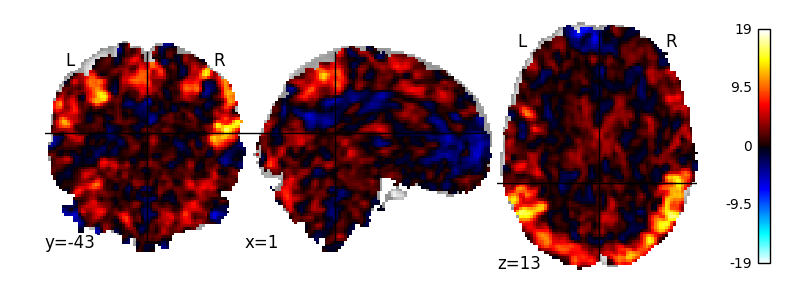

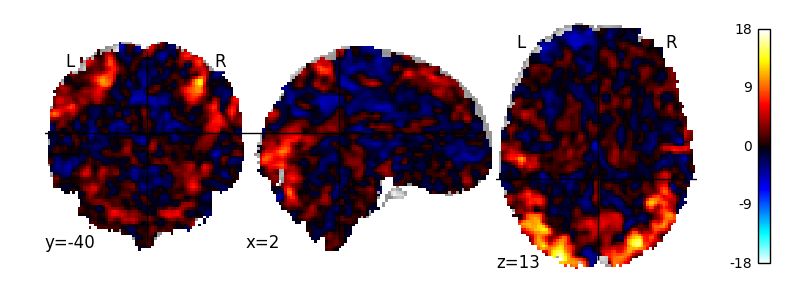

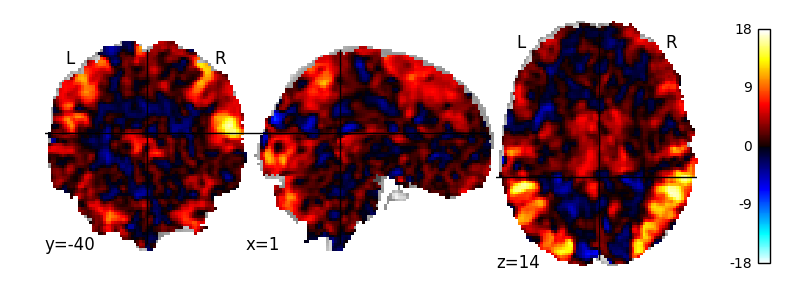

In [505]:
from nilearn import plotting

plotting.plot_stat_map(image.load_img(subjects[0].z_maps['ALL_MOTION']))
plotting.plot_stat_map(image.load_img(subjects[1].z_maps['ALL_MOTION']))
plotting.plot_stat_map(image.load_img(subjects[2].z_maps['ALL_MOTION']))


(array([  1.00000000e+01,   5.80000000e+01,   1.72000000e+02,
          6.89000000e+02,   1.92800000e+03,   5.26300000e+03,
          1.19650000e+04,   2.39470000e+04,   3.87890000e+04,
          7.21442000e+05,   4.34000000e+04,   2.95350000e+04,
          1.51740000e+04,   6.49700000e+03,   2.55300000e+03,
          9.08000000e+02,   2.29000000e+02,   5.10000000e+01,
          1.50000000e+01,   4.00000000e+00]),
 array([-6.78792483, -6.09057808, -5.39323132, -4.69588457, -3.99853782,
        -3.30119107, -2.60384431, -1.90649756, -1.20915081, -0.51180406,
         0.1855427 ,  0.88288945,  1.5802362 ,  2.27758295,  2.9749297 ,
         3.67227646,  4.36962321,  5.06696996,  5.76431671,  6.46166347,
         7.15901022]),
 <a list of 20 Patch objects>)

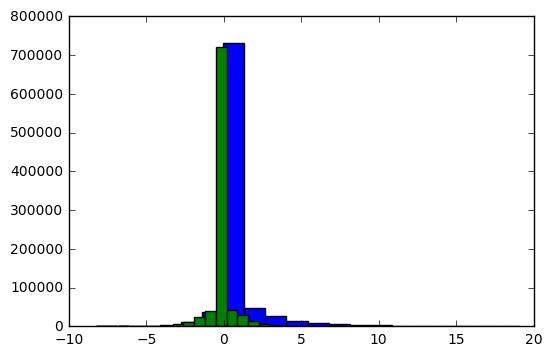

In [598]:
plt.hist(image.load_img(subjects[0].z_maps['ALL_MOTION']).get_data().ravel(), bins=20)
plt.hist(image.load_img(subjects[0].z_maps['TOM-RANDOM']).get_data().ravel(), bins=20)


## 4.1 second-level analysis 

### simple second level analysis nilearn

In [342]:
# from nilearn.input_data import NiftiMasker
# from nilearn.masking import intersect_masks

# zmaps = [image.load_img(subject.z_maps['ALL_MOTION']) for subject in subjects]
# m_zmaps = [nibabel.Nifti1Image(np.where(zmap.get_data() > 0, 
#                                         np.full(zmaps[i].shape, 1, np.int64), 
#                                         np.full(zmaps[i].shape, 0, np.int64)),
#                                affine = zmaps[i].affine) for i,zmap in enumerate(zmaps)]

# intersected_mask = intersect_masks(m_zmaps, 1)

# group_mask = nibabel.Nifti1Image(
#     intersected_mask, 
#     affine = intersected_mask.affine)

### one-sample t-test using the GLM formalism

In [516]:
from nipy.labs.mask import intersect_masks
from nipy.modalities.fmri.glm import FMRILinearModel
# from nibabel import load, concat_images, save, Nifti1Image

In [517]:
zmaps_con1 = [subject.z_maps['ALL_MOTION'] for subject in subjects]
zmaps_con2 = [subject.z_maps['TOM-RANDOM'] for subject in subjects]

contrasts_images = [zmaps_con1, zmaps_con2]
contrasts_names = ['ALL_MOTION', 'TOM-RANDOM']

In [518]:
contrasts_images

[['C:\\data\\graduate_thesis\\hcp_data_sample\\output\\100307\\z_maps\\z_ALL_MOTION.nii',
  'C:\\data\\graduate_thesis\\hcp_data_sample\\output\\103414\\z_maps\\z_ALL_MOTION.nii',
  'C:\\data\\graduate_thesis\\hcp_data_sample\\output\\105115\\z_maps\\z_ALL_MOTION.nii'],
 ['C:\\data\\graduate_thesis\\hcp_data_sample\\output\\100307\\z_maps\\z_TOM-RANDOM.nii',
  'C:\\data\\graduate_thesis\\hcp_data_sample\\output\\103414\\z_maps\\z_TOM-RANDOM.nii',
  'C:\\data\\graduate_thesis\\hcp_data_sample\\output\\105115\\z_maps\\z_TOM-RANDOM.nii']]

In [523]:
options['contrasts_names'] = contrasts_names

In [530]:
%%time
group_contrasts_imgs = []
group_contrasts_masks = []

for con_imgs, con_n in zip(contrasts_images, contrasts_names):
    print("\tcontrast id: %s" % con_n)
    
    # Compute a population-level mask as the intersection of individual masks
    grp_mask = nibabel.Nifti1Image(intersect_masks(con_imgs).astype(np.int8),
                       nibabel.load(subjects[0].mask).affine)
    # concatenate the individual images
    first_level_image = nibabel.concat_images(con_imgs)
    
    # set the model
    design_matrix = np.ones(len(con_imgs))[:, np.newaxis]  # only the intercept
    
    grp_model = FMRILinearModel(first_level_image, design_matrix, grp_mask)
    
    # GLM fitting using ordinary least_squares
    print('Fitting a "Fixed Effect" GLM for group')
    grp_model.fit(do_scaling=False, model='ols')
    print("... done.\r\n")
    
    # save computed mask
    mask_path = os.path.join(output_dir, "group_mask_%s.nii"%con_n)
    print("Saving group mask image to %s ..." % mask_path)
    nibabel.save(grp_model.mask, mask_path)
    print("... done.\r\n")
    group_contrasts_masks.append(mask_path)
    
    # specify and estimate the contrast
    contrast_val = np.array(([[1]]))  # the only possible contrast 
    z_map, = grp_model.contrast(contrast_val, con_id='one_sample_%s'%con_n, output_z=True)
    
    # save computed z map
    zmap_path = os.path.join(output_dir, 'one_sample_z_map_%s.nii'%con_n)
    print("Saving z map image to %s ..." % zmap_path)
    nibabel.save(z_map, zmap_path)
    print("... done.\r\n")
    group_contrasts_imgs.append(zmap_path)
    

options['group_contrasts_masks'] = group_contrasts_masks 
options['group_contrasts_zmaps'] = group_contrasts_imgs


	contrast id: ALL_MOTION
Fitting a "Fixed Effect" GLM for group
... done.

Saving group mask image to C:\data\graduate_thesis\hcp_data_sample\output\group_mask_ALL_MOTION.nii ...
... done.

Saving z map image to C:\data\graduate_thesis\hcp_data_sample\output\one_sample_z_map_ALL_MOTION.nii ...
... done.

	contrast id: TOM-RANDOM
Fitting a "Fixed Effect" GLM for group
... done.

Saving group mask image to C:\data\graduate_thesis\hcp_data_sample\output\group_mask_TOM-RANDOM.nii ...
... done.

Saving z map image to C:\data\graduate_thesis\hcp_data_sample\output\one_sample_z_map_TOM-RANDOM.nii ...
... done.

Wall time: 384 ms


In [531]:
options['group_contrasts_masks']

['C:\\data\\graduate_thesis\\hcp_data_sample\\output\\group_mask_ALL_MOTION.nii',
 'C:\\data\\graduate_thesis\\hcp_data_sample\\output\\group_mask_TOM-RANDOM.nii']

In [532]:
options['group_contrasts_zmaps']

['C:\\data\\graduate_thesis\\hcp_data_sample\\output\\one_sample_z_map_ALL_MOTION.nii',
 'C:\\data\\graduate_thesis\\hcp_data_sample\\output\\one_sample_z_map_TOM-RANDOM.nii']

In [533]:
# first_level_image.shape

(91, 109, 91, 3)

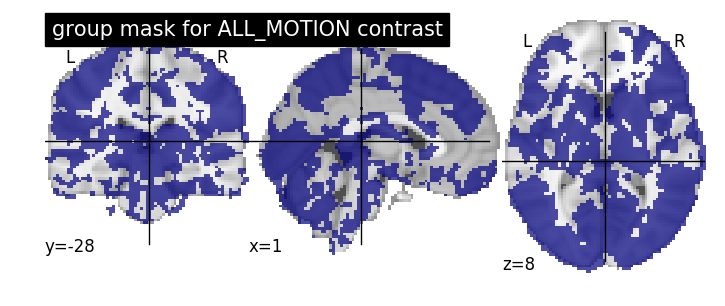

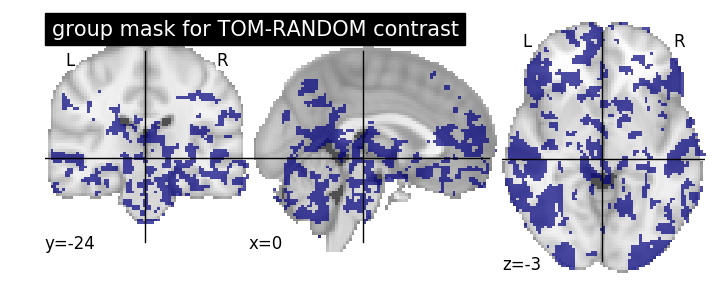

In [537]:
plotting.plot_roi(options['group_contrasts_masks'][0], title='group mask for %s contrast'%(options['contrasts_names'][0]))
plotting.plot_roi(options['group_contrasts_masks'][1], title='group mask for %s contrast'%(options['contrasts_names'][1]))

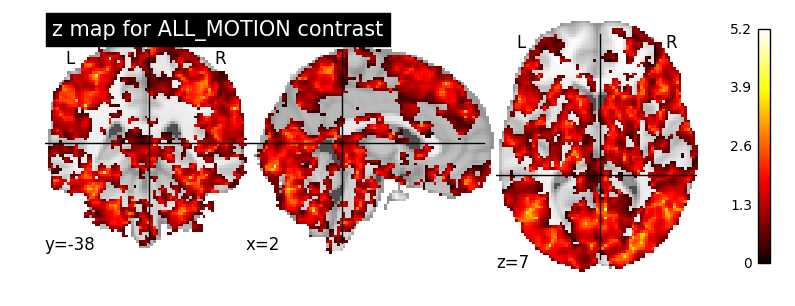

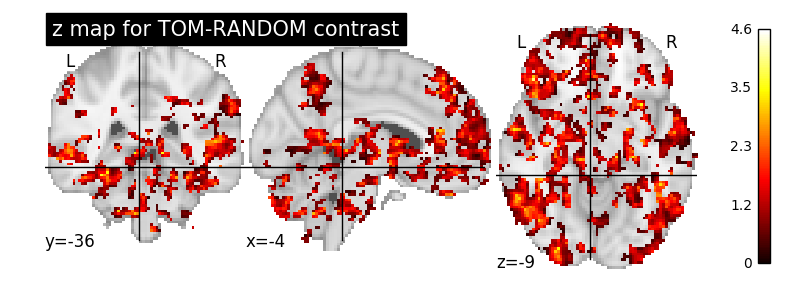

In [536]:
plotting.plot_stat_map(options['group_contrasts_zmaps'][0], title='z map for %s contrast'%(options['contrasts_names'][0]))
plotting.plot_stat_map(options['group_contrasts_zmaps'][1], title='z map for %s contrast'%(options['contrasts_names'][1]))

In [650]:
def jsonify(data):
    json_data = dict()
    for key, value in data.items():
        if isinstance(value, list): # for lists
            value = [ jsonify(item) if isinstance(item, dict) else item for item in value ]
        if isinstance(value, dict): # for nested lists
            value = jsonify(value)
        if isinstance(key, int): # if key is integer: > to string
            key = str(key)
        if type(value).__module__=='numpy': # if value is numpy.*: > to python list
            if len(value.shape) == 1:
                value = value.tolist()
            else:
                value = [v.tolist() for v in value]
        json_data[key] = value
    return json_data


import json
json.dump(jsonify(options),
          open(os.path.join(output_dir,
                            "options.json"), "w"))

In [649]:
# for subject in subjects:
#     json.dump(jsonify(vars(subject)),
#               open(os.path.join(output_dir,
#                                 "subject%s_res_dict.json"%subject.subject_id), "w"))

## 4.2 roi

In [559]:
# mask = nibabel.load(subjects[0].func[0]).get_data() > 0
# plotting.plot_roi(nibabel.Nifti1Image(mask[:,:,:,0].astype(int), nibabel.load(subjects[0].brainmasks[0]).affine))
# plotting.plot_roi(subjects[0].brainmasks[0])

In [744]:
%%time
from nistats.thresholding import map_threshold
thresholded_map, threshold = map_threshold(options['group_contrasts_zmaps'][0], 
                                           threshold=.05, 
                                           height_control='fpr', 
                                           cluster_threshold=10)

Wall time: 1.44 s


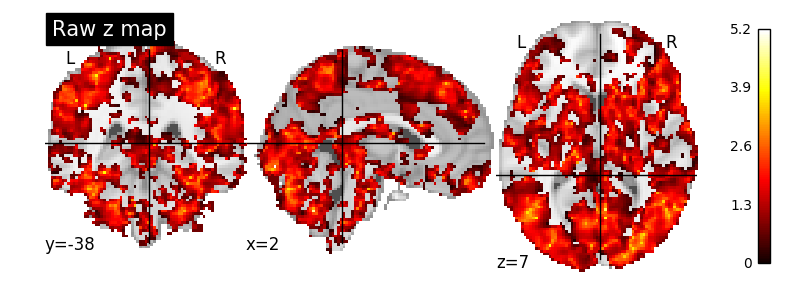

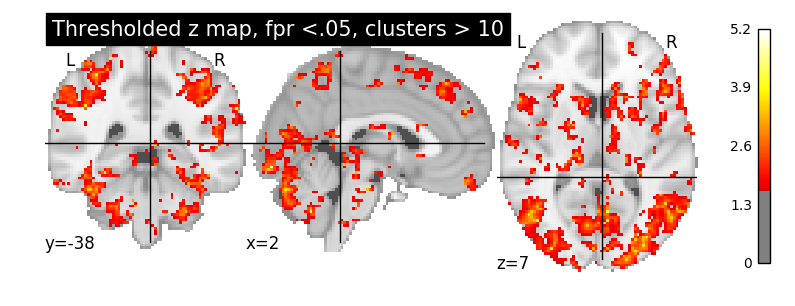

In [746]:
display = plotting.plot_stat_map(options['group_contrasts_zmaps'][0], title='Raw z map')
plotting.plot_stat_map(thresholded_map, cut_coords=display.cut_coords, threshold=threshold,
    title='Thresholded z map, fpr <.05, clusters > 10')

In [659]:
import nipy.labs.spatial_models.mroi as mroi
from nipy.labs.spatial_models.discrete_domain import grid_domain_from_image
import nipy.labs.spatial_models.hroi as hroi

In [781]:
roi_positions = np.array([[[44, -64, 4]], [[-44, -74, 4]], [[54, -50, 16]], [[-56, -52, 10]]])
roi_names = ['r_V5', 'l_V5', 'r_pSTS', 'l_pSTS']

roi_info = dict((k,{'position': v}) for k,v in zip(roi_names, roi_positions))

In [782]:
roi_info

{'l_V5': {'position': array([[-44, -74,   4]])},
 'l_pSTS': {'position': array([[-56, -52,  10]])},
 'r_V5': {'position': array([[ 44, -64,   4]])},
 'r_pSTS': {'position': array([[ 54, -50,  16]])}}

In [785]:
%%time
# -----------------------------------------------------
# create the ROI from a given position
# -----------------------------------------------------
roi_info1 = dict((k,{'position': v}) for k,v in zip(roi_names, roi_positions))
for roi_position, roi_name in zip(roi_positions,roi_names):
    print('Finding domain for %s (pos %s)...'%(roi_name, roi_position))
#     if 'pSTS' in roi_name:
#         domain = grid_domain_from_image(options['group_contrasts_masks'][1])
#     else:    
#         domain = grid_domain_from_image(options['group_contrasts_masks'][0])
    domain = grid_domain_from_image(subjects[0].mask) #?
    roi = mroi.subdomain_from_balls(domain, roi_position, np.array([6.0]))
    roi_domain = domain.mask(roi.label > -1)
    dom_img = roi_domain.to_image()
    print("... done.\r\n")
    roi_info1[roi_name]['domain'] = domain
    roi_info1[roi_name]['roi'] = roi
    roi_info1[roi_name]['roi_domain'] = roi_domain
    roi_info1[roi_name]['dom_img'] = dom_img


Finding domain for r_V5 (pos [[ 44 -64   4]])...
... done.

Finding domain for l_V5 (pos [[-44 -74   4]])...
... done.

Finding domain for r_pSTS (pos [[ 54 -50  16]])...
... done.

Finding domain for l_pSTS (pos [[-56 -52  10]])...
... done.

Wall time: 911 ms


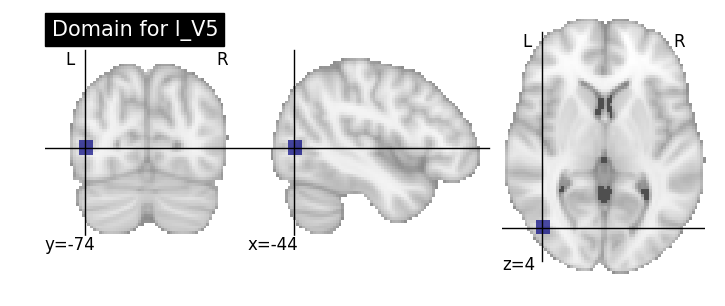

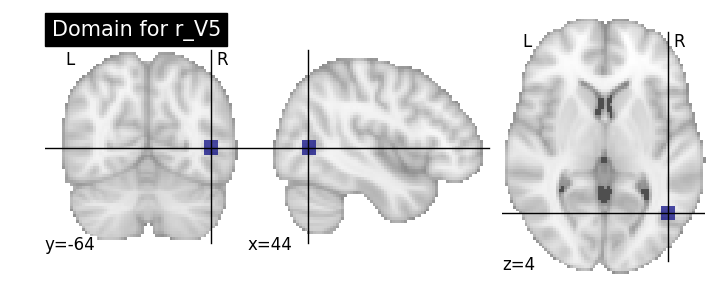

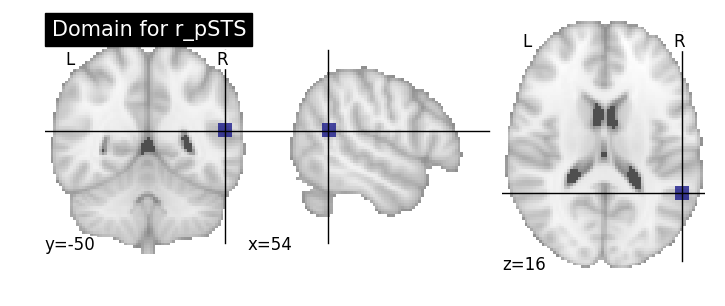

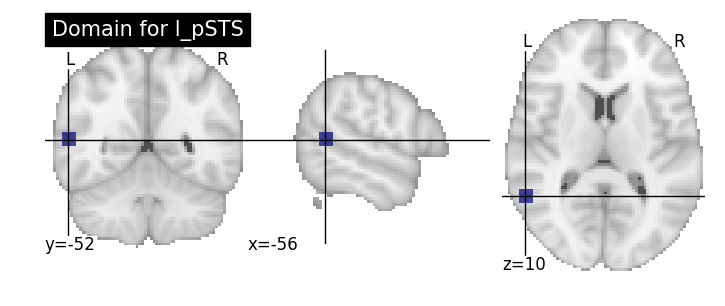

In [789]:
for k,v in roi_info1.items():
    plotting.plot_roi(v['dom_img'], title='Domain for %s'%k)

In [743]:
# vmin, vmax = roi_info['r_V5']['dom_img'].get_data().min(), roi_info['r_V5']['dom_img'].get_data().max()
# plot_map(roi_info['r_V5']['dom_img'].get_data(), 
#          roi_info['r_V5']['dom_img'].affine,
#          cmap=cm.cold_hot, 
#          vmin=vmin,
#          vmax=vmax,
#          do3d=True)

# from nipy.labs import viz3d
# try:
#     viz3d.plot_map_3d(roi_info1['r_V5']['dom_img'].get_data(), 
#                       roi_info1['r_V5']['dom_img'].affine,
#                       cmap=cm.cold_hot,
#                       vmin=vmin,
#                       vmax=vmax)
# except ImportError:
#     print("Need mayavi for 3D visualization")

In [831]:
%%time
# ----------------------------------------------------
# ---- create ROIs from a blob image ------
# ----------------------------------------------------
# parameters
threshold = 0.05  # blob-forming threshold
smin = 1  # size threshold on bblobs

roi_info2 = dict((k,{'position': v}) for k,v in zip(roi_names, roi_positions))

for roi_position, roi_name in zip(roi_positions,roi_names):
    if 'V5' in roi_name:
        domain = grid_domain_from_image(options['group_contrasts_masks'][0]) #?
        nim = nibabel.load(options['group_contrasts_zmaps'][0])
        data = nim.get_data()
        values = data[data != 0]
        # compute the nested roi object
        nroi = hroi.HROI_as_discrete_domain_blobs(domain, values,
                                                  threshold=threshold, smin=smin)

        # saving the blob image, i.e. a label image
        wim = nroi.to_image('id', roi=True)
        roi = mroi.subdomain_from_position_and_image(wim, roi_position[0])
        wim3 = roi.to_image()
#         roi_path_3 = os.path.join(output_dir, "blob_closest_to_%d_%d_%d.nii"
#                                   % (position[0][0], position[0][1], position[0][2]))
#         nibabel.save(wim3, roi_path_3)

        #     print('Finding domain for %s (pos %s)...'%(roi_name, roi_position))
# #     if 'pSTS' in roi_n:
# #         domain = grid_domain_from_image(options['group_contrasts_masks'][1])
# #     else:    
# #         domain = grid_domain_from_image(options['group_contrasts_masks'][0])
#     domain = grid_domain_from_image(subjects[0].mask) #?
#     roi = mroi.subdomain_from_balls(domain, roi_position, np.array([6.0]))
#     roi_domain = domain.mask(roi.label > -1)
#     dom_img = roi_domain.to_image()
#     print("... done.\r\n")
#     roi_info[roi_name]['domain'] = domain
#     roi_info[roi_name]['roi'] = roi
#     roi_info[roi_name]['roi_domain'] = roi_domain
#     roi_info[roi_name]['dom_img'] = dom_img
    


Wall time: 2min 46s


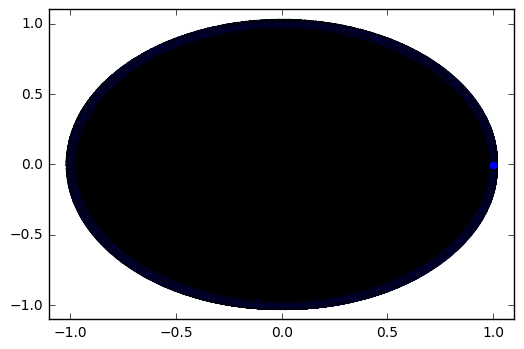

In [836]:
nroi.make_forest().show()

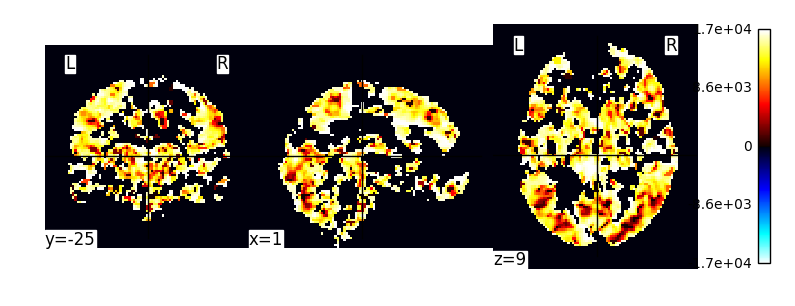

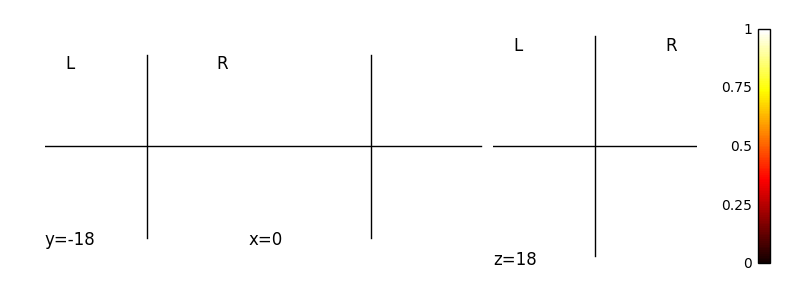

In [837]:
plotting.plot_stat_map(wim)
plotting.plot_stat_map(wim3)

## 5.1 connectivity

In [340]:
import nitime
#Import the time-series objects:
from nitime.timeseries import TimeSeries
#Import the analysis objects:
from nitime.analysis import CorrelationAnalyzer, CoherenceAnalyzer, granger, GrangerAnalyzer
#Import utility functions:
from nitime.utils import percent_change
from nitime.viz import drawmatrix_channels, drawgraph_channels, plot_xcorr

# import nitime
# import nitime.analysis as nta
# import nitime.timeseries as ts
# import nitime.utils as tsu
# from nitime.viz import drawmatrix_channels

In [339]:
#This information (the sampling interval) has to be known in advance:
TR = options['TR']
f_lb = 0.02
f_ub = 0.15

In [ ]:
data = 

In [ ]:
pdata = percent_change(data)
time_series = TimeSeries(pdata, sampling_interval=TR)

In [ ]:
G = GrangerAnalyzer(time_series, order=1)

In [ ]:
C1 = CoherenceAnalyzer(time_series)
C2 = CorrelationAnalyzer(time_series)

In [ ]:
freq_idx_G = np.where((G.frequencies > f_lb) * (G.frequencies < f_ub))[0]
freq_idx_C = np.where((C1.frequencies > f_lb) * (C1.frequencies < f_ub))[0]

In [ ]:
coh = np.mean(C1.coherence[:, :, freq_idx_C], -1)  # Averaging on the last dimension
g1 = np.mean(G.causality_xy[:, :, freq_idx_G], -1)

fig01 = drawmatrix_channels(coh, roi_names, size=[10., 10.], color_anchor=0)

In [ ]:
fig02 = drawmatrix_channels(C2.corrcoef, roi_names, size=[10., 10.], color_anchor=0)

In [ ]:
fig03 = drawmatrix_channels(g1, roi_names, size=[10., 10.], color_anchor=0)

In [ ]:
g2 = np.mean(G.causality_xy[:, :, freq_idx_G] - G.causality_yx[:, :, freq_idx_G], -1)
fig04 = drawmatrix_channels(g2, roi_names, size=[10., 10.], color_anchor=0)

    http://nipy.org/nitime/examples/resting_state_fmri.html